# Cursive English Handwritten Character Classification: Exploratory Data Analysis
# ------------------------------------------------------------------------------

### Notebook Overview:
This notebook will be used to explore and understand the cursive handwriting dataset derived from the CVL database. We will be:
1. Previewing Dataset
2. Check Data Quality and Clean
3. Class Distribution Analysis
4. Visual Explorations
5. Statistical Summaries
6. Preliminary Feature or Embedding Analysis
7. EDA Conclusion

In [2]:
%pip install torchsummary pytest
%pip install pandas matplotlib seaborn pillow torchvision scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
from importlib import reload

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if flag_cuda:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


## 1. Preview the Data
### In this section, we will:
### 1. Examine the folder structure for our dataset.
### 2. Count how many files are in each subdirectory.
### 3. Visualize a few random images from the `lines`, `pages`, and `words` directories.

Folder Structure and File Counts:
- lines: 13473 files found
- pages: 1604 files found
- words: 99904 files found
- xml: 1604 files found
Displaying random images from 'lines' folder:


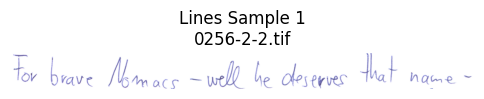

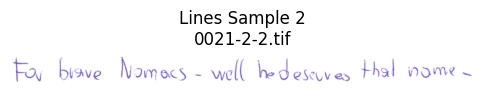

Displaying random images from 'pages' folder:


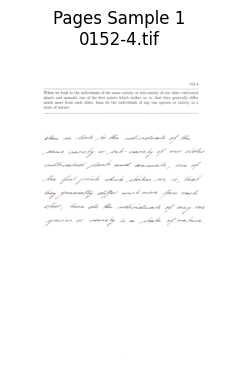

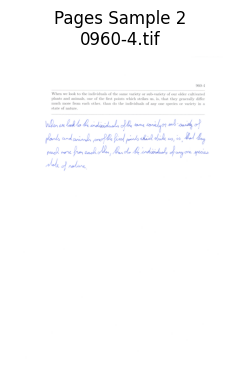

Displaying random images from 'words' folder:


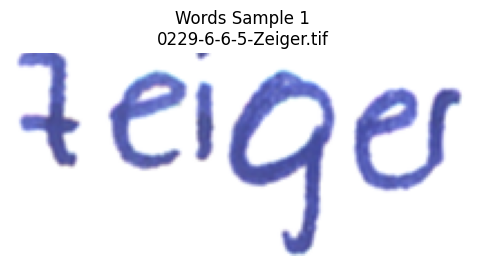

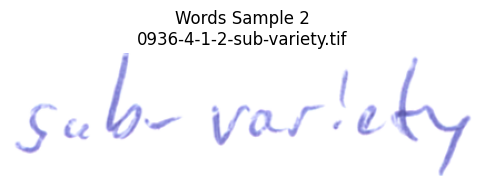

--- lines Stats (from 100 samples) ---
Most common widths: [(1754, 2), (1757, 2), (1810, 2), (1658, 2), (1874, 2)]
Most common heights: [(110, 4), (134, 4), (116, 3), (133, 3), (146, 3)]
Image modes: Counter({'RGB': 100})

--- pages Stats (from 100 samples) ---
Most common widths: [(2539, 5), (2536, 4), (2563, 4), (2511, 4), (2496, 3)]
Most common heights: [(3548, 5), (3546, 5), (3565, 4), (3529, 4), (3513, 3)]
Image modes: Counter({'RGB': 100})

--- words Stats (from 100 samples) ---
Most common widths: [(102, 3), (134, 3), (162, 3), (148, 3), (164, 2)]
Most common heights: [(100, 4), (87, 3), (89, 3), (95, 3), (64, 3)]
Image modes: Counter({'RGB': 100})



In [4]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Base path to the CVL database
BASE_PATH = 'cvl-database-1-1/full_dataset'

# Subfolders in the full_dataset directory
subfolders = ['lines', 'pages', 'words', 'xml']

# 1. Folder Structure and File Counts

print("Folder Structure and File Counts:")
for folder in subfolders:
    folder_path = os.path.join(BASE_PATH, folder)

    # Get all files (recursively), adjusting the pattern as needed for your file types
    all_files = glob.glob(os.path.join(folder_path, '**', '*.*'), recursive=True)
    print(f"- {folder}: {len(all_files)} files found")

# 2. Random Image Preview

def show_random_image(folder_name, num_samples=1):
    """
    Display 'num_samples' random images from the specified folder (including its subfolders).
    """
    folder_path = os.path.join(BASE_PATH, folder_name)

    # Find image files; adjust for your file extension(s): *.tif, *.png, *.jpg, etc.
    image_files = glob.glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)

    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return

    # Randomly sample from the list of image files
    random_files = random.sample(image_files, k=min(num_samples, len(image_files)))

    for i, file_path in enumerate(random_files, 1):
        img = Image.open(file_path)
        plt.figure(figsize=(6, 4))
        plt.imshow(img, cmap='gray')  # Assuming grayscale images
        plt.title(f"{folder_name.capitalize()} Sample {i}\n{os.path.basename(file_path)}")
        plt.axis('off')
        plt.show()

for folder_name in ['lines', 'pages', 'words']:
    print(f"Displaying random images from '{folder_name}' folder:")
    show_random_image(folder_name, num_samples=2)

# 3. Image Statistics (Dimensions and Modes)

def get_image_stats(folder_name, num_samples=100):
    """
    Gather statistics on image dimensions (width, height) and mode (e.g., L, RGB)
    from a random subset of images in the specified folder.
    """
    # Build and normalize the folder path
    folder_path = os.path.normpath(os.path.join(BASE_PATH, folder_name))

    if not os.path.isdir(folder_path):
        print(f"Folder does not exist: {folder_path}")
        return

    # Find image files with the .tif extension (adjust the extension if necessary)
    image_files = glob.glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)
    # Normalize each file path
    image_files = [os.path.normpath(f) for f in image_files]

    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return

    # Take a random subset of files to analyze
    random_files = random.sample(image_files, min(num_samples, len(image_files)))

    sizes = []
    modes = []

    for file_path in random_files:
        try:
            with Image.open(file_path) as img:
                sizes.append(img.size)  # (width, height)
                modes.append(img.mode)  # e.g., "L" or "RGB"
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    width_counts = Counter([size[0] for size in sizes])
    height_counts = Counter([size[1] for size in sizes])
    mode_counts = Counter(modes)

    print(f"--- {folder_name} Stats (from {len(random_files)} samples) ---")
    print(f"Most common widths: {width_counts.most_common(5)}")
    print(f"Most common heights: {height_counts.most_common(5)}")
    print(f"Image modes: {mode_counts}")
    print()

# Test the function on folders: lines, pages, and words
for folder_name in ['lines', 'pages', 'words']:
    get_image_stats(folder_name, num_samples=100)

# 2. Data Quality and Cleaning

In [3]:
import os
import glob
import re

# Base path to the CVL database, normalized for the current OS
BASE_PATH = os.path.normpath('cvl-database-1-1/full_dataset')

def filter_german_files(folder_name, extension='tif'):
    folder_path = os.path.normpath(os.path.join(BASE_PATH, folder_name))
    all_files = glob.glob(os.path.join(folder_path, '**', f'*.{extension}'), recursive=True)
    all_files = [os.path.normpath(f) for f in all_files]

    # Filter out files where the base name contains '-6-'
    filtered_files = [f for f in all_files if not re.search(r'-6-', os.path.basename(f))]

    print(f"Folder: {folder_name} - Original count: {len(all_files)}, Filtered count: {len(filtered_files)}")
    return filtered_files

# Process both 'lines' and 'words' folders
lines_filtered = filter_german_files('lines')
words_filtered = filter_german_files('words')

Folder: lines - Original count: 13473, Filtered count: 11007
Folder: words - Original count: 99904, Filtered count: 69184


In [10]:
from PIL import Image, ImageOps
import os

def resize_image_to_uniform_size(image_path, target_width, target_height):
    # Open the image
    img = Image.open(image_path)
    
    # Get the current size of the image
    current_width, current_height = img.size
    
    # Calculate padding
    padding_left = (target_width - current_width) // 2
    padding_top = (target_height - current_height) // 2
    padding_right = target_width - current_width - padding_left
    padding_bottom = target_height - current_height - padding_top
    
    # Add padding to the image
    padded_img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom), (255, 255, 255))
    
    return padded_img

def process_images_in_folder(file_list, target_width, target_height, output_path):
    # Loop through all files in the folder
    for filename in file_list:
        if filename.lower().endswith('.tif'):  # Process only .tif files
            padded_image = resize_image_to_uniform_size(filename, target_width, target_height)
            output_path_save = os.path.join(output_path, os.path.basename(filename)) 
            # Save the padded image
            padded_image.save(output_path_save)

lines_folder_path = os.path.normpath(os.path.join(BASE_PATH, 'lines_padded'))
words_folder_path = os.path.normpath(os.path.join(BASE_PATH, 'words_padded'))

# Set the target size (you can change this as needed)
target_width = 1756  # Largest width from the stats
target_height = 146  # Largest height from the stats

# Process all .tif images in the folder
process_images_in_folder(lines_filtered, target_width, target_height, lines_folder_path)
process_images_in_folder(words_filtered, target_width, target_height, words_folder_path)